Project 4 - Scientific Computing - Kimi Kreilgaard (Twn176)

In [127]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook

# Helper Functions

In [2]:
def update_ghosts(matrix):
    """
    Uses central difference to ensure the no-flux Neunmann boundary conditions. The "ghosts" are an extra border
    around the box which value is set to the same as the value on the other side of the border. This ensures
    that when we use the laplacian on elements near the border (elements with indices containing 1 or 41) which
    is calculated from neighbouring elements, there will be no flux out of the box since fx. elements 0 and 1
    will be the same
    """
    # Make a copy of the matrix so we don't change the original matrix
    matrix = matrix.copy()
    
    # Upper border
    matrix[0,1:-1] = matrix[1, 1:-1]
    
    # Lower border
    matrix[-1,1:-1] = matrix[-2,1:-1]
    
    # Left border
    matrix[1:-1,0] = matrix[1:-1,1]
    
    # Right border
    matrix[1:-1,-1] = matrix[1:-1,-2]
    
    return matrix

In [3]:
def Laplacian(matrix, step_size=1):
    """
    Function that calculates the laplacian for all elements in the matrix except for ghost elements. Assumes
    that the step size in each direction is the same: dx=dy=step_size.
    
    Matrix = matrix with ghosts
    """
    
    # Get submatrices
    inner = matrix[1:-1, 1:-1]
    up = matrix[:-2,1:-1]
    down = matrix[2:,1:-1]
    left = matrix[1:-1,:-2]
    right = matrix[1:-1,2:]
    
    # Laplacian for x
    d2mat_dx2 = (1/step_size**2) * ( left - 2*inner + right )
    
    # Laplacian for y
    d2mat_dy2 = (1/step_size**2) * ( down - 2*inner + up )
    
    # Full laplacian
    Lap = d2mat_dx2 + d2mat_dy2
    
    return Lap

In [7]:
def update_state(P_matrix, Q_matrix, dt, params, step_size=1):
    """
    Functions that updates/simulate the state of the reaction diffusion process by one time step dt.
    P_matrix and Q_matrix with ghosts. Returns P_matrix and Q_matrix with (non_updated) ghosts too.
    
    params = list with four parameters D_p, D_q, C, K
    """
    # Exract parameters
    D_p, D_q, C, K = params[0], params[1], params[2], params[3]
    
    # Get inner matrices
    P_inner = P_matrix[1:-1, 1:-1]
    Q_inner = Q_matrix[1:-1, 1:-1]
    
    # Get Laplacians
    Nabla_P = Laplacian(P_matrix, step_size)
    Nabla_Q = Laplacian(Q_matrix, step_size)
    
    # Get timederivatives
    dP_matrix = D_p * Nabla_P + P_inner**2 * Q_inner + C - (K+1)*P_inner
    dQ_matrix = D_q * Nabla_Q - P_inner**2 * Q_inner + K*P_inner
    
    # Calculate the new matricies P(t+dt)=P(t)+dt*dP/dt and Q(t+dt)=Q(t)+dt*dQ/dt
    P_new = P_inner + dt*dP_matrix
    Q_new = Q_inner + dt*dQ_matrix
    
    # Make matrices size 43x43 again, add ghosts
    P_matrix[1:-1, 1:-1] = P_new
    Q_matrix[1:-1, 1:-1] = Q_new
    
    return P_matrix, Q_matrix

In [8]:
def plotter(P,Q):
    fig, ax = plt.subplots(ncols=2)
    mini, maks = np.min((P, Q)), np.max((P, Q))
    im = ax[0].imshow(P, cmap='Greys', vmin=mini, vmax=maks)
    ax[0].set_title('P with ghosts')
    ax[1].imshow(Q, cmap='Greys', vmin=mini, vmax=maks)
    ax[1].set_title('Q with ghosts')
    cax = plt.axes([0.95, 0.2, 0.05, 0.58])
    fig.colorbar(im, cax=cax)
    plt.show()

# Simulate for K=9

  0%|          | 0/2000000 [00:00<?, ?it/s]

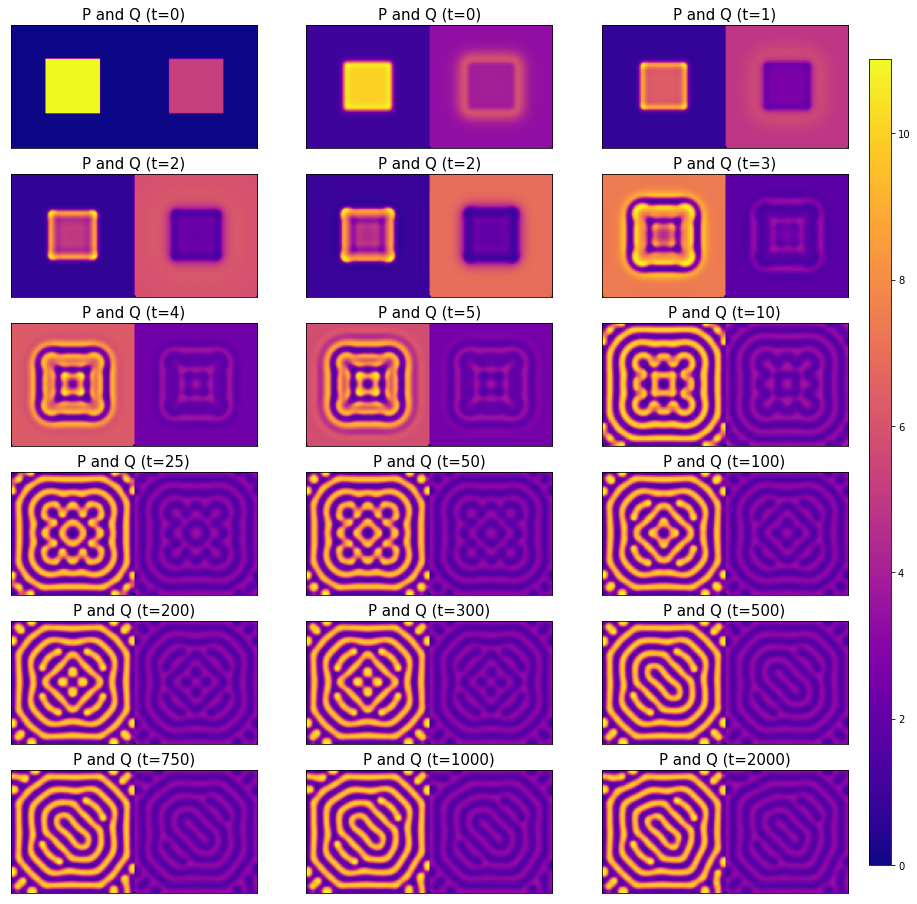

In [149]:
################
#### SET UP ####
################

# Parameter values
D_p, D_q, C, K = 1, 8, 4.5, 9

# Choose dx=dy - OBS: Has to be a number that ensures N is an integer
dx = 0.5

# Calculate side length of matrix with more gridspace
N = int( 43 / dx )

# Create the matrices for P and Q
P_mat = np.zeros((N,N))
Q_mat = np.zeros((N,N))

# Fill out initial values
"""
Update with the initial conditions belong to squares 10<x<30 and 10<y<30 in P_inner 
(11 free on each side). In the ghosts matrix there is two more rows and columns thus we use: 
11<x<31 and 11<y<31 (12 free on each side) if dx=1
"""
low, high = int(12/dx), int(31/dx)
P_mat[low:high,low:high] = C + 0.1
Q_mat[low:high,low:high] = K/C + 0.2


##########################
#### CONSTRUCT FIGURE ####
##########################

fig, axes = plt.subplots(ncols=3, nrows=6, figsize=(15,16))
axes = axes.flatten()

# Remove ticks
for ax in axes:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
##########################
#### SIMULATE AND PLOT ###
##########################

# Choose time step size and how many time steps to simulate
dt = 0.001
t = 2000

# Make lists to store frames to plot later
P_frames = []
Q_frames = []

# Choose which times to freeze (should be same len as axes)
t_freeze = [0, 5e2, 1e3, 1.5e3, 2e3, 3e3,
            4e3, 5e3, 1e4, 2.5e4, 5e4, 1e5,
            2e5, 3e5, 5e5, 7.5e5, 1e6, 2e6-1]

# Loop over the time iterations
for time in tqdm_notebook(range( int(t/dt) )):

    # Update ghosts
    P_mat = update_ghosts(P_mat)
    Q_mat = update_ghosts(Q_mat)
    
    # Save 12 freezed frames
    if time in t_freeze:
        P_frames.append(P_mat)
        Q_frames.append(Q_mat)
        
    # Update state
    P_mat, Q_mat = update_state(P_mat, Q_mat, dt, params=(D_p, D_q, C, K), step_size=dx)

# Plot P and Q together in the same ax object for all axes (with shared colorbar)
mini, maks = np.min(np.concatenate((P_frames,Q_frames))), np.max(np.concatenate((P_frames,Q_frames)))
for i, ax in zip(np.arange(len(axes)), axes):
    ax.imshow( np.concatenate((P_frames[i],Q_frames[i]), axis=1), cmap='plasma' )
    ax.set_title(f'P and Q (t={np.round(t_freeze[i]*dt):.0f})', fontsize=15)
    
# Add colorbar
cax = plt.axes([0.92, 0.15, 0.02, 0.7]) #[left, bottom, width, height]
fig.colorbar(im, cax=cax)

# Save figure
plt.savefig('k9.png')
plt.show()

# All K's

  0%|          | 0/6 [00:00<?, ?it/s]

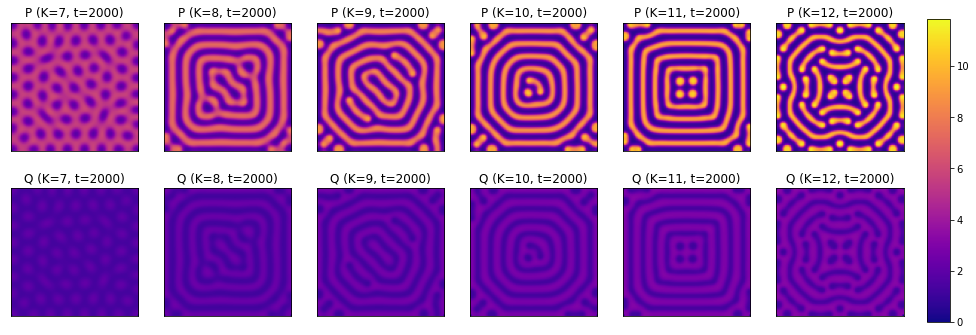

In [151]:
###################################
#  Now we do it with all the K's  #
###################################

# Parameter values
D_p, D_q, C = 1, 8, 4.5
K_arr = np.arange(7,13,1)

# Places to store P and Q matrices
P_list = []
Q_list = []

# Choose dx=dy - OBS: Has to be a number that ensures N is an integer
dx = 0.5

# Calculate side length of matrix with more gridspace
N = int( 43 / dx )

# Loop over K's
for K in tqdm_notebook(K_arr):

    # Create the matrices for P and Q
    P_mat = np.zeros((N,N))
    Q_mat = np.zeros((N,N))

    # Fill out initial values
    """
    Update with the initial conditions belong to squares 10<x<30 and 10<y<30 in P_inner 
    (11 free on each side). In the ghosts matrix there is two more rows and columns thus we use: 
    11<x<31 and 11<y<31 (12 free on each side) if dx=1
    """
    low, high = int(12/dx), int(31/dx)
    P_mat[low:high,low:high] = C + 0.1
    Q_mat[low:high,low:high] = K/C + 0.2
    
    dt = 0.001
    t = 2000
    
    for i in range( int(t/dt) ):
        
        # Update ghosts
        P_mat = update_ghosts(P_mat)
        Q_mat = update_ghosts(Q_mat)
    
        # Update state
        P_mat, Q_mat = update_state(P_mat, Q_mat, dt, params=(D_p, D_q, C, K), step_size=dx)
    
    # Store the end results
    P_list.append(P_mat)
    Q_list.append(Q_mat)
    
### Plotting it ###

# Set up figure
fig, ax = plt.subplots(nrows=2, ncols=len(K_arr), figsize=(16,6), gridspec_kw={'wspace':0.2, 'hspace':0.03})

# Finding the minimum and maximum value for the collective colorbar
mini, maks = np.min((P_list, Q_list)), np.max((P_list, Q_list))

# Plotting
for i in range(len(K_arr)):
    im = ax[0,i].imshow(P_list[i], cmap='plasma', vmin=mini, vmax=maks)
    ax[0,i].set_title('P (K={}, t=2000)'.format(K_arr[i]))
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)
    
    ax[1,i].imshow(Q_list[i], cmap='plasma', vmin=mini, vmax=maks)
    ax[1,i].set_title('Q (K={}, t=2000)'.format(K_arr[i]))
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)

# Add colorbar
cax = plt.axes([0.92, 0.15, 0.02, 0.7]) #[left, bottom, width, height]
fig.colorbar(im, cax=cax)

# Save fig
plt.savefig('k_all.png')
plt.show()